# Multiclass classification

## Learning objectives
- Understand how classification can be implemented when there are more than 2 classes
- Implement a multiclass classifier from scratch

## Intro - Binary classification vs multiclass classification

In binary classification the output must be either true or false. Either the example falls into this class, or it doesn't. We have seen that we can represent this by our model having a single output node whose value is forced between 0 and 1, and as such represents a confidence in the fact that the example belongs to the positive class. Alternatively, still for binary classification, we could have two output nodes, where the value of the first represents the confidence that the input belongs to the positive class (true/class 1) and the value of the second represents the confidence that the input belongs to the negative class (false/class 2). In this case, the values of each output node must be positive and they must sum to 1, because this output layer represents a probability distribution over the output classes. 

# Softmax

![](./images/binary-class.jpg)

In the case where we have two nodes to represent true and false, we can think about it as having trained two models.

Treating true and false as separate classes with separate output nodes shows us how we can extend this idea to do multiclass classification; we simply add more nodes and ensure that their values are positive and sum to one.

![](./images/multiclass.jpg)

### What function can we use to convert the output layer into a distribution over classes?

The **softmax function** exponentiates each value in a vector to make it positive and then divides each of them by their sum to normalise them (make them sum to 1). This ensures that the vector then can be interpreted as a probability distribution.

![](./images/softmax.jpg)

Example

![](./images/softmax_example.jpg)

## Differentiating the softmax

![](images/softmax_deriv.jpg)

### Properties of softmax
- increasing the value of any entry decreases the value of all of the others, because the whole vector must always sum to one. 
- an increase in one input element increases it's corresponding output element exponentially whilst pushing others down, this means that it is easy for the one largest output element to become the only one not close to zero. 

### What does the name "softmax" mean?
- as explained above, it's easy for only one input to be near 1, and all others close to zero. That is, the max input becomes the only non-zero element. So in this case, the softmax basically set all elements but the max to zero.
- the output of the max element of a vector changes abruptly when one element becomes larger than the current max. It suffers a "hard" change. Unlike this, the softmax function changes gradually when the max changes - we call this a "soft" change as it is continuous.

Let's implement our own softmax function, and again include a boolean flag that will return the gradient.

In [40]:
import numpy as np

def softmax(z, label=None, grad=False):
    if grad:
        num_classes = z.shape[1]

        g = softmax(z) * (1 - softmax(z))

        # g = np.zeros((num_classes, num_classes))
        # for i in range(num_classes):
        #     for j in range(num_classes):
        #         if j == i:
        #             g[i][j] = softmax(z)[i] * (1 - softmax(z)[i])
        #         else:
        #             g[i][j] = - softmax(z)[i] * softmax(z)[j]
        return g

    # print(np.sum(z, axis=1))
    # print(np.exp(z))
    return (np.exp(z).T / np.sum(np.exp(z), axis=1)).T

x = np.random.rand(3, 2)
print(x)
print(softmax(x))
print('softmax sums up to:', np.sum(softmax(x), axis=1))
print()
print('gradient:')
print(softmax(x, label=2, grad=True))

[[0.0510183  0.89327668]
 [0.39620149 0.28488938]
 [0.25017732 0.80644358]]
[[0.30105936 0.69894064]
 [0.52779933 0.47220067]
 [0.36441181 0.63558819]]
softmax sums up to: [1. 1. 1.]

gradient:
[[0.21042262 0.21042262]
 [0.2492272  0.2492272 ]
 [0.23161584 0.23161584]]


## The cross entropy loss function

In the BCE loss function, the one line equation contained all of the "switches" that it needs to turn on or off certain terms of the equation.
This was possible because in binary classification, the labels will certainly either be 0 or 1.

In multiclass classification however, these switches cannot be contained in a single line.

An appropriate loss function to use for multiclass classification is the cross entropy loss function.
Like BCE loss, cross entropy uses the same term: the negative natural log of the output probability to penalise outputs exponentially as they stray from the ground truth.

We don't need to simultaneously push down the incorrect class probabilities and push up the correct class probabilities.
This is because by increasing the value of one element of the output of a softmax, the others must decrease, because the whole vector has to sum to 1.
So if we focus on increasing the correct class likelihood element, then we will implicitly be decreasing the incorrect class likelihood elements.

![](images/cross_entropy_loss.jpg)

Let's implement the cross entropy loss function.

In [16]:
def CrossEntropyLoss(z, label, grad=False):
    if grad:
        return - 1 / z
    return np.sum(- np.log(z))

Other than the final layer of the model where the softmax is applied and the loss function, the model and algorithm stay the same. 

Of course however, changing the model changes the gradient of the loss function with respect to the model parameters.
So we'll need to change the code that performs the parameter updates.

Below is the same code we wrote to perform binary classification

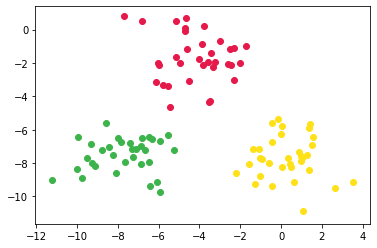

In [24]:
from utils import get_classification_data, show_data

num_classes=3

X, Y = get_classification_data(sd=1.5, m=100, n_clusters=num_classes)
X.shape
show_data(X, Y)

In [25]:
import matplotlib.pyplot as plt

class Classifier:
    def __init__(self, n_features, n_classes):
        self.w = np.random.rand(n_features, n_classes)
        self.b = np.random.rand(n_classes)
    
    def __call__(self, x):
        x = np.matmul(x, self.w) + self.b
        x = softmax(x)
        return x

    def update_params(self, new_w, new_b):
        self.w = new_w
        self.b = new_b    

    def calc_deriv(self, x, y_hat, label):
        m = len(Y) # m = number of examples
        diffs = y_hat - label # calculate errors
        dzdb = 1
        dzdw = x # needs to be distributed
        dhdz = softmax(y_hat, label, grad=True)
        print(dhdz.shape)
        print(dzdw.shape)
        dhdw = np.matmul(dhdz, dzdw)
        dhdb = dhdz * dzdb
        print('dhdw:', dhdw)
        ssdc
        return dhdw, dhdb


In [28]:
from utils import visualise_predictions

H = Classifier(n_features=2, n_classes=3)

# softmax(X)
H(X)
# np.sum(H(X), axis=0)

# visualise_predictions(H, X, Y) # visualise predictions before training

array([[1.84368697e-02, 8.88761737e-04, 7.30957572e-03],
       [6.96953505e-04, 2.37013617e-05, 3.69418975e-04],
       [1.16913603e-03, 8.26452177e-06, 2.88271346e-04],
       [2.49747994e-02, 4.08457806e-04, 5.88953402e-03],
       [8.62703349e-03, 7.17792732e-04, 4.82770317e-03],
       [8.67171121e-04, 5.09451149e-06, 2.05166023e-04],
       [2.04717992e-02, 1.25462277e-03, 8.89856560e-03],
       [7.86828767e-04, 9.02678014e-06, 2.53644576e-04],
       [8.42508990e-03, 6.84844549e-04, 4.68136464e-03],
       [7.14986267e-03, 1.70724911e-02, 1.81274704e-02],
       [1.31638568e-02, 2.19618972e-04, 3.41626665e-03],
       [6.05903428e-03, 7.16935733e-05, 1.50074625e-03],
       [3.43309659e-03, 2.02185385e-02, 1.43375012e-02],
       [6.50804428e-03, 1.17397174e-04, 1.92385017e-03],
       [4.98803263e-04, 2.05263042e-06, 1.08674540e-04],
       [2.04398576e-04, 2.83544118e-07, 3.10691349e-05],
       [6.53101335e-03, 4.52863003e-03, 9.69924049e-03],
       [1.24332015e-02, 2.50888

In [9]:
learning_rate = 0.001

H = Classifier(n_features=2, n_classes=3)

epochs = 1000
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, y in zip(X, Y):
        prediction = H(x)
        # print(y)
        loss = CrossEntropyLoss(prediction, y)
        epoch_losses.append(loss)
        dhdw, dhdb = H.calc_deriv(x, prediction, y)
        # print(prediction)
        print('dhdw')
        print(dhdw)
        print(dhdw.shape)

        print('dhdb')
        print(dhdb)
        print(dhdb.shape)


        dLdh = CrossEntropyLoss(prediction, y, grad=True)
        print('dLdh:')
        print(dLdh.shape)
        print(dLdh)
        print('dhdw')
        print(dhdw)
        print(dhdw.shape)
        dLdw = dLdh * dhdw
        print(dLdw)
        dLdb = dLdh * dhdb
        new_w = H.w - learning_rate * dLdw
        new_b = H.b - learning_rate * dLdb
        H.update_params(new_w, new_b)
    plot_hypothesis(X, H, ax=ax1)
    fig.canvas.draw()
    losses.append(np.mean(epoch_losses))
        


(3, 3)
(2,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

Plot class probability landscape for each class
Evaluate mesh and plot probability of being a member of each class vertically 

## Summary
- multiclass classification requires a different loss function 
- softmax is a differentiable function that turns a vector of real numbers into a probability distribution

## Next steps
- 
